In [1]:
# data: https://download.pytorch.org/tutorial/data.zip
import io
import os
import unicodedata
import string
import glob

import torch
import random

import matplotlib.pyplot as plt

In [2]:
# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

print("ALL LETTERS: ", ALL_LETTERS)

ALL LETTERS:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [3]:
# find the index of string
ALL_LETTERS.find('Q')

42

### Function to Convert Sequence/Words into ASCII

In [4]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

In [5]:
unicode_to_ascii('Bagas Nu7521r Prayoga1238/>')

'Bagas Nur Prayoga'

### Function to Load Data

In [6]:
def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        # Return a list of paths matching a pathname pattern.
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        # Open file and return a stream
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories

In [7]:
data = load_data()

In [8]:
category_lines, all_categories = data

In [9]:
type(data)

tuple

In [10]:
# dict of country with its all names, and list of all countries/categories
type(data[0]), type(data[1])

(dict, list)

In [11]:
n_outputs = len(data[1])
n_outputs

18

## Function to Turn Names into Tensor

In [12]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_tensor('J'))

print(line_to_tensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Create RNN Model

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class RNN(nn.Module):

    # initialize RNN Parameters
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        # store input size and hidden size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # defining nodes
        self.i2h = nn.Linear(self.input_size, self.hidden_size)
        self.h2h = nn.Linear(self.hidden_size, self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, self.output_size)

        # softmax function
        self.softmax = nn.LogSoftmax(dim=1)

    # forward step
    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    # initialize hidden
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
# example
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_outputs)

### Create RNN Model : Demonstration

In [16]:
input = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)

output, hidden = rnn(input, hidden)

In [17]:
output

tensor([[-2.8674, -2.9173, -3.0055, -2.8191, -2.8899, -3.0916, -2.8097, -2.9425,
         -3.0609, -2.8661, -2.8857, -2.7996, -2.8648, -2.9192, -2.7719, -2.8875,
         -2.8155, -2.8749]], grad_fn=<LogSoftmaxBackward0>)

In [18]:
torch.argmax(output)

tensor(14)

In [19]:
all_categories[torch.argmax(output, dim=-1)]

'Russian'

## Training

### Training : Helper Function for Training

In [20]:
# helper function to get a tuples of category and its corresponding category names
def category_from_output(output):
    category_i = torch.argmax(output, dim=-1).item()
    return all_categories[category_i], category_i

In [21]:
category_from_output(output)

('Russian', 14)

In [22]:
# helper function to create random training examples

# random choice
def random_choice(lis):
    return lis[random.randint(0, len(lis)-1)]

# random training example
def random_training_example():
    # get the category --> ex: 'English'
    category = random_choice(all_categories)

    # get the name within the category
    line = random_choice(category_lines[category])

    # create a category tensor from category index within all_categories list
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    # create a tensor line
    line_tensor = line_to_tensor(line)

    return category, line, category_tensor, line_tensor

In [27]:
for i in range(20):
    category, line, category_line, line_tensor = random_training_example()
    print(f"category = {category} || line = {line}")
    print(category_line)
    print(category_line.size())

category = Italian || line = Aita
tensor([9])
torch.Size([1])
category = Spanish || line = Villanueva
tensor([16])
torch.Size([1])
category = Irish || line = Naoimhin
tensor([8])
torch.Size([1])
category = Polish || line = Mencher
tensor([12])
torch.Size([1])
category = Irish || line = O'Mahoney
tensor([8])
torch.Size([1])
category = Irish || line = Suaird
tensor([8])
torch.Size([1])
category = Korean || line = Ko
tensor([11])
torch.Size([1])
category = Chinese || line = Shuo
tensor([1])
torch.Size([1])
category = Irish || line = O'Brien
tensor([8])
torch.Size([1])
category = Greek || line = Phocas
tensor([7])
torch.Size([1])
category = Dutch || line = Peerenboom
tensor([3])
torch.Size([1])
category = Japanese || line = Tagawa
tensor([10])
torch.Size([1])
category = Portuguese || line = Fonseca
tensor([13])
torch.Size([1])
category = German || line = Raskoph
tensor([6])
torch.Size([1])
category = Chinese || line = Koo
tensor([1])
torch.Size([1])
category = Russian || line = Velli
tenso

### Training : Training Phase

Each Loop of training will:
* create input and target tensor
* create zeros initial hidden state
* read each letter in and keep hidden state for next letter
* compare final output to target
* back-propagate
* return the output and lossutput and loss

In [28]:
# if you set it too low it will not learn anything, but if it set too high it will explode
learning_rate = 0.005

In [29]:
# we'll use `nn.LLLoss()` since the last layer of the RNN is nn.LogSoftmax
criterion = nn.NLLLoss()

# optimize will use Stochastic Gradient Descent
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

In [30]:
def train(category_tensor, line_tensor):
    # initialize hidden input of zeros
    hidden = rnn.init_hidden()

    # empty the gradient
    rnn.zero_grad()

    # re-run the procedure for n number of letter within name
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # compute loss and gradient
    loss = criterion(output, category_tensor)

    # zero grad
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [147]:
import time
import math

n_iters = 100000
print_every = 2500
plot_every = 1000

# keep track loss for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters+1):
    # get training examples
    category, line, category_tensor, line_tensor = random_training_example()

    # train the model
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # track the losses
    if iter % plot_every == 0:
        # append the average losses
        all_losses.append(current_loss/plot_every)
        # set current loss back to zero
        current_loss = 0

    # print the result
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        
        if guess == category: 
            correct = 'TRUE' 
        else: correct = 'FALSE'+f' ({category})'

        print(f"{iter} {100*iter/n_iters :.0f} {time_since(start)} {loss:.4f}=={line} / {guess} {correct}")

2500 2 0m 4s 1.9362==Breda / Spanish FALSE (Dutch)
5000 5 0m 9s 0.1496==Ondrisek / Czech TRUE
7500 8 0m 13s 0.3960==Matos / Portuguese TRUE
10000 10 0m 20s 0.0181==Teague / Irish TRUE
12500 12 0m 27s 0.3505==Lobo / Portuguese TRUE
15000 15 0m 33s 0.2244==Blazek / Czech TRUE
17500 18 0m 38s 1.3410==Smith / English FALSE (Scottish)
20000 20 0m 44s 0.0034==Locatelli / Italian TRUE
22500 22 0m 50s 0.0086==Zouvelekis / Greek TRUE
25000 25 0m 56s 0.0009==Totah / Arabic TRUE
27500 28 1m 1s 0.6289==Maloney / English TRUE
30000 30 1m 7s 0.1524==Sullivan / Irish TRUE
32500 32 1m 13s 0.4524==Aleppo / Italian TRUE
35000 35 1m 19s 3.6836==Durant / French FALSE (English)
37500 38 1m 25s 0.1028==Xiang / Chinese TRUE
40000 40 1m 30s 0.3716==Murphy / Scottish TRUE
42500 42 1m 36s 0.0261==Mateus / Portuguese TRUE
45000 45 1m 42s 1.4709==Schneider / Czech FALSE (Dutch)
47500 48 1m 48s 2.5126==Mulder / German FALSE (Dutch)
50000 50 1m 54s 0.0014==Ochida / Japanese TRUE
52500 52 2m 0s 0.3415==Vickery / Eng

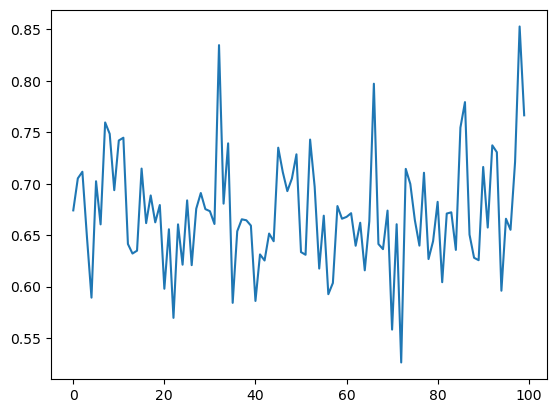

In [148]:
plt.plot(all_losses)

In [138]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [139]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [149]:
predict('Yanbarisov')


> Yanbarisov
(-0.00) Russian
(-6.65) Czech
(-6.73) English


In [150]:
predict('Sarkozi')


> Sarkozi
(-0.53) Italian
(-1.95) Japanese
(-2.15) Spanish


In [151]:
predict('Trotman')


> Trotman
(-0.77) English
(-1.35) French
(-2.26) German


In [155]:
rnn.parameters

<bound method Module.parameters of RNN(
  (i2h): Linear(in_features=57, out_features=128, bias=True)
  (h2h): Linear(in_features=128, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)>